In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import pytorch_lightning as pl

import sklearn as sk
import functools
import operator

import sys

import optuna

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import lat_dataset_load_new_lightning
#import struct_torch_net_class_lightning
import custom_torch_net_class_lightning

import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [3]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [4]:
checkpoint_path = "pl_checkpoints/CustomNet-003-epoch=178-val_loss=1.51679E-08.ckpt"

In [5]:
#best_model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path,hyper_parameters)
model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path)

model.to(device)

model.configure_loss()

model.eval()

CustomNet(
  (cnn): Net(
    (layers): ModuleList(
      (0): AsymmetricCircularPadding()
      (1): Conv2d(4, 64, kernel_size=[2, 2], stride=[1, 1])
      (2): ReLU()
      (3): AsymmetricCircularPadding()
      (4): Conv2d(64, 64, kernel_size=[2, 2], stride=[1, 1])
      (5): ReLU()
      (6): AsymmetricCircularPadding()
      (7): Conv2d(64, 64, kernel_size=[2, 2], stride=[1, 1])
      (8): ReLU()
      (9): AdaptiveAvgPool2d(output_size=[1, 1])
      (10): ReLU()
    )
  )
  (dense1): Net(
    (layers): ModuleList(
      (0): Reshape()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (loss): BCELoss()
)

In [6]:
#conv = best_model.cnn.layers[1]
#conv.weight

In [7]:
#mlpconv = best_model.cnn.layers[4]
#mlpconv.weight

In [8]:
#[phi2, n]
test_lat_size = [2,2]
#test_lat_size = [5,5]

#kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
#kl_conf[:,1,0,:,:] = 0
kl_conf[:,0,0,:,:] = 0
input_conf = kl_conf.reshape(1,4,*test_lat_size)
model(input_conf)

tensor([[3.5108e-10]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [9]:
"""calculate f"""
def link_per_lat_point(links, lat_size, dims):

    #empty channels where the linsk on other directions should be saved
    #empty_link_channels = np.zeros(links.shape)
    #empty_link_channels = torch.zeros(*links.shape, dtype=int)
    empty_link_channels = links.clone()
    for d in range(dims):
        #print(d)
        #print(links)
        d_links = links[d]
        #print(d_links)
        #perm_links = np.roll(d_links, shift=1, axis=d)
        perm_links = torch.roll(d_links, shifts=1, dims=d)
        #print(perm_links)
        
        #print(d_slices)
        #empty_link_channels[d] = links[zip(d_slices)]
        empty_link_channels[d] = perm_links
        
    #not supported
    #empty_link_channels = empty_link_channels[::-1]
    #torch.flip(input=empty_link_channels, dims=[0])
    
    #complete_links = np.concatenate((links,empty_link_channels), axis=0)
    complete_links = torch.cat((links,empty_link_channels), dim=0)
            
            
    return complete_links

def f_calc(k_links, l_links, lat_size, dims):
    full_k_links = link_per_lat_point(k_links, lat_size, dims)
    full_l_links = link_per_lat_point(l_links, lat_size, dims)
    #print(full_k_links.shape)
    #print(full_l_links.shape)
    
    #abs_full_k_links = np.abs(full_k_links)
    abs_full_k_links = torch.abs(full_k_links)
    
    #calc_f = (abs_full_k_links + 2*full_l_links).sum(axis=0).astype(int)
    calc_f = (abs_full_k_links + 2*full_l_links).sum(axis=0)

    #return calc_f.astype(int)
    return calc_f

In [10]:
"""test k flux conservation"""
k_max = 40

net_outputs = torch.zeros(k_max)

for i in tqdm(range(k_max)):
    
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    kl_conf[:,0,:,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    output = model(input_conf.to("cuda:0"))
    #print(output)
    net_outputs[i] = output

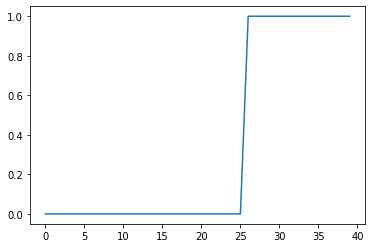

In [12]:
int_net_outputs = np.rint(net_outputs.detach().numpy())
plt.plot(np.arange(k_max), int_net_outputs)

In [13]:
"""test k flux conservation"""
k_max = 40

net_outputs = torch.zeros(k_max)

for i in tqdm(range(k_max)):
    
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    kl_conf[:,0,0,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    output = model(input_conf.to("cuda:0"))
    #print(output)
    net_outputs[i] = output

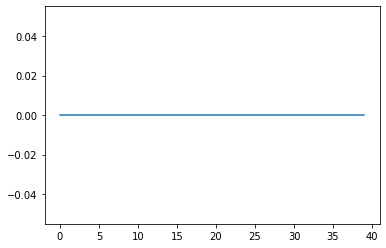

In [14]:
int_net_outputs = np.rint(net_outputs.detach().numpy())
plt.plot(np.arange(k_max), int_net_outputs)

In [15]:
"""test k flux conservation"""
k_max = 40

net_outputs = torch.zeros(k_max)

for i in tqdm(range(k_max)):
    
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    kl_conf[:,0,1,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    output = model(input_conf.to("cuda:0"))
    #print(output)
    net_outputs[i] = output

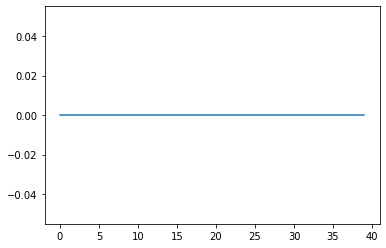

In [16]:
int_net_outputs = np.rint(net_outputs.detach().numpy())
plt.plot(np.arange(k_max), int_net_outputs)

In [17]:
"""test k flux conservation"""
k_max = 40

net_outputs = torch.zeros(k_max)

for i in tqdm(range(k_max)):
    
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    kl_conf[:,1,:,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    output = model(input_conf.to("cuda:0"))
    #print(output)
    net_outputs[i] = output
    

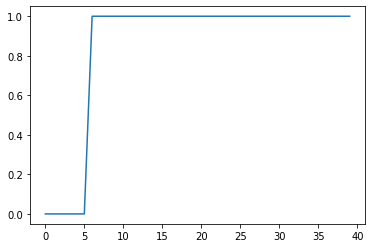

In [18]:
int_net_outputs = np.rint(net_outputs.detach().numpy())
plt.plot(np.arange(k_max), int_net_outputs)

In [19]:
"""test k flux conservation"""
k_max = 40

net_outputs = torch.zeros(k_max)

for i in tqdm(range(k_max)):
    
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    kl_conf[:,:,:,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    output = model(input_conf.to("cuda:0"))
    #print(output)
    net_outputs[i] = output
    

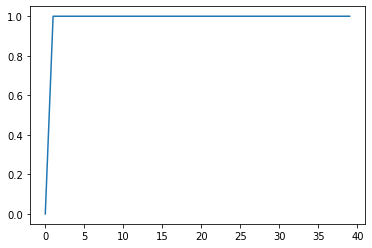

In [20]:
int_net_outputs = np.rint(net_outputs.detach().numpy())
plt.plot(np.arange(k_max), int_net_outputs)

In [29]:
lat_size = [2,2]
#lat_size = [5,5]
#lat_size = [10,10]
dims = len(lat_size)
link_max = 30
conf_size = np.concatenate(([2],lat_size))
num_conf = 100000
#num_conf = 100
random_size = tuple(np.concatenate(([num_conf], conf_size)))

k_links = torch.randint(low=-link_max, high=link_max+1, size=random_size)
l_links = torch.randint(low=0, high=link_max, size=random_size)


physical_conf_indices = []

open_labels = torch.ones(num_conf)

for conf_i in tqdm(range(num_conf)):
    if torch.all(k_links[conf_i,0].sum() == 0):
        physical_conf_indices.append(conf_i)
        open_labels[conf_i] = 0
    
print(len(physical_conf_indices))


1067


In [30]:
confs = torch.cat((k_links, l_links), dim=1)
#torch_confs = torch.tensor(confs, device="cuda:0")
torch_confs = confs.to("cuda:0")

In [31]:
net_outputs = model(torch_confs.float()).detach().cpu().numpy()

int_net_outputs = np.rint(net_outputs)

[[    2  1065]
 [   54 98879]]


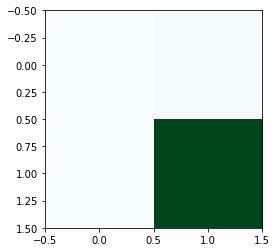

In [32]:
conf_mat = sk.metrics.confusion_matrix(open_labels, int_net_outputs)
#conf_mat = conf_mat/len(labels)
print(conf_mat)
plt.imshow(conf_mat, cmap="BuGn")